# sub-n-classes, Tsallis Entropy labelling

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
import time
from random import *

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
def randints_nodup(k):
    ns = []
    while (len(ns) < k):
        n = randint(0, 9)
        if not n in ns:
            ns.append(n)
    return list(ns)

In [3]:
# entropy labelling
def tsallis_label(q, probas, s_cls):
    elements = np.power(probas, q - 1)
    # thrshld in tsallis entropy model
    ts_thrshld = np.sum(np.power(probas, q))
    if q < 1:
        labels = [s_cls[i] for i, e in enumerate(elements) if e <= ts_thrshld]
    else:
        labels = [s_cls[i] for i, e in enumerate(elements) if e >= ts_thrshld]
    return labels

In [4]:
def flip_label(pair, label):
    p_list = list(pair)
    flipped = [c for c in p_list if (c != label)]
    return flipped[0]

In [5]:
def flip_cond():
    r = random()
    if r <= 0.25:
        return True
    else:
        return False

#### ラベルづけからその正解率の評価まで行う関数

In [9]:
# labelling and evaluating them
def tsallis_ncls_eval(q, classes_num, orig_A, lim_A):
    s_cls = randints_nodup(classes_num)
    s_cls.sort()
    print(s_cls)
    
    # confusing pairs ... see LR-misclassification-habits.pdf
    conf_pairs = [{0, 8}, {0, 6}, 
                  {1, 8}, {1, 2}, 
                  {2, 8}, {2, 3}, 
                  {3, 5}, {3, 2}, 
                  {4, 9}, {4, 8},
                  {5, 3}, {5, 8}, 
                  {6, 2}, {6, 5}, 
                  {7, 9}, {7, 2},
                  {8, 5}, {8, 9}, 
                  {9, 7}, {9, 4}]
    
    # 選ばれたクラスだけのデータとラベルを用意
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]
    # flip some labels
    flip_flags = [True if c_pair < set(s_cls) else False for c_pair in conf_pairs]
    
    for i, label in enumerate(trn_labels):
        for j, flag in enumerate(flip_flags):
            if (flag and flip_cond() and label in conf_pairs[j]):
                trn_labels[i] = flip_label(conf_pairs[j], label)

    # generate an annotator
    a1_model = LR(max_iter = 200).fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_proba = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [tsallis_label(q, probas, s_cls) for probas in a1_proba]
    
    # labels score evaluation
    score = 0
    for labels, t_label in zip(mul_labels, trn_labels[orig_A:orig_A + lim_A]):
        for l in labels:
            if (l == t_label):
                score += 1

    m_labels = []
    for labels in mul_labels:
         [m_labels.append(l) for l in labels]                
                    
    return (len(m_labels)/lim_A, score*100/len(m_labels), score*100/lim_A) 

## MNIST

In [7]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

img_SIZE = train_images.shape[1]*train_images.shape[2]

Using TensorFlow backend.


### labels evaluation

In [8]:
for classes_num in range(2, 11):
    print(f"{classes_num} classes")
    orig_A1, lim_A1 = 2000, 2000
    q = 0.99
    (ave_l_num, labels_qual, labels_qual2) = tsallis_ncls_eval(q, classes_num, orig_A1, lim_A1)
    print(f"quality of labels generated: {labels_qual}[%], {labels_qual2}[%](as groups)")
    print(f"average number of labels per image: {ave_l_num}")

2 classes
[8, 9]


/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


quality of labels generated: 96.7[%], 96.7[%](as groups)
average number of labels per image: 1.0
3 classes
[1, 4, 6]
quality of labels generated: 98.69934967483742[%], 98.65[%](as groups)
average number of labels per image: 0.9995
4 classes
[3, 7, 8, 9]


/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


quality of labels generated: 56.12293144208038[%], 59.35[%](as groups)
average number of labels per image: 1.0575
5 classes
[0, 2, 3, 7, 8]


/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


quality of labels generated: 37.83783783783784[%], 43.4[%](as groups)
average number of labels per image: 1.147
6 classes
[1, 2, 3, 4, 5, 9]


/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


quality of labels generated: 40.0[%], 44.9[%](as groups)
average number of labels per image: 1.1225
7 classes
[0, 3, 4, 6, 7, 8, 9]


/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


quality of labels generated: 36.5803534730785[%], 44.5[%](as groups)
average number of labels per image: 1.2165
8 classes
[0, 1, 2, 3, 5, 6, 7, 9]


/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


quality of labels generated: 34.05511811023622[%], 43.25[%](as groups)
average number of labels per image: 1.27
9 classes
[0, 1, 2, 3, 4, 5, 6, 7, 8]


/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


quality of labels generated: 28.040163629602084[%], 37.7[%](as groups)
average number of labels per image: 1.3445
10 classes
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
quality of labels generated: 22.123579545454547[%], 31.15[%](as groups)
average number of labels per image: 1.408


/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
results = [96.7, 98.69934967483742, 56.12293144208038, 37.83783783783784, 40.0, 36.5803534730785, 34.05511811023622, 28.040163629602084, 22.123579545454547] 

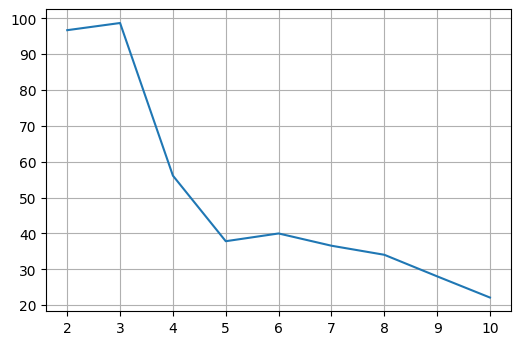

In [11]:
x = [i for i in range(2, 11)]
plt.figure(dpi = 100)
plt.plot(x, results)
plt.grid(True)

## CIFAR 10

In [10]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

### labels evaluation

In [7]:
classes_num = 3
orig_A2, lim_A2 = 2000, 2000
q = 3/2
(ave_l_num, labels_qual, labels_qual2) = tsallis_eval(q, classes_num, orig_A2, lim_A2)
print(f"quality of labels generated: {labels_qual}[%], {labels_qual2}[%](as groups)")
print(f"average number of labels per image: {ave_l_num}")

[1, 6, 8]
quality of labels generated: 95.70214892553723[%], 95.75[%](as groups)
average number of labels per image: 1.0005


## CIFAR100

In [8]:
from keras.datasets import cifar100

(train_images, train_labels), (test_images, test_labels) = cifar100.load_data(label_mode = "fine")

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

### labels evaluation

In [9]:
classes_num = 3
orig_A3, lim_A3 = 500, 500
q = 3/2
(ave_l_num, labels_qual, labels_qual2) = tsallis_eval(q, classes_num, orig_A3, lim_A3)
print(f"quality of labels generated: {labels_qual}[%], {labels_qual2}[%](as groups)")
print(f"average number of labels per image: {ave_l_num}")

[1, 2, 9]
quality of labels generated: 66.27450980392157[%], 67.6[%](as groups)
average number of labels per image: 1.02
